# Classification example of Slic on unseen data from Hinode/SOT

This notebook acts a primer on how to use Slic to prep solar image data directly from fits files and classify them. In this example we use data from 2014/10/17 from Hinode/SOT. The images used for classification will be images of a prominence in H&alpha; &lambda;6563.

Packages needed to run this notebook are:

* `PyTorch`
* `numpy`
* `maptlotlib`
* `scitkit-image`
* `astropy`
* (optionally) `palettable`

In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from palettable.cmocean.sequential import Solar_20 #optional import comment out if you don't have palettable
import html, os, warnings
from astropy.io.fits import getdata
from skimage.transform import resize
from utils import *
from tqdm import tqdm_notebook
from IPython.core.display import display,HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
angstrom = html.unescape("&#8491;")

model_pth = "solClass73.pth"
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #check for a CUDA device
sol_cm = Solar_20.mpl_colormap
warnings.filterwarnings("ignore",append=True)
class bad_data(Exception): pass

The first course of action is to load in the data and to prep it.

In [29]:
im_list = sorted(["example_data/"+x for x in os.listdir("example_data/")])
new_im_list = []
for i, image in tqdm_notebook(enumerate(im_list)):
    tmp = getdata(image).astype(np.float64)
    try:
        for (x,y), pixel in np.ndenumerate(tmp):
            if tmp[x,y] == 0:
                raise bad_data() #skip over images with faults in the data
    except bad_data:
        continue
    tmp = resize(tmp,(256,256),anti_aliasing=True)
    tmp = tmp.reshape(1,256,256)
    new_im_list.append(tmp)
    
print("There are %d images to be classified" % len(new_im_list))
new_im_arr = np.array(new_im_list)
del(new_im_list)


There are 1735 images to be classified


Now that the data has been loaded in to a `numpy.ndarray` we can classify the images easily using the `solar_classification` function.

In [3]:
ans_dict, ans_hist_dict = solar_classification(weights=model_pth,data=new_im_arr)

Classifying images: 1735it [00:37, 46.36it/s]


In [5]:
ans_dict

{'filaments': array([], dtype=int16),
 'flares': array([], dtype=int16),
 'prominences': array([   0,    1,    2, ..., 1732, 1733, 1734], dtype=int16),
 'quiet': array([], dtype=int16),
 'sunspots': array([], dtype=int16)}

In [6]:
ans_hist_dict

{'filaments': array([], shape=(0, 5), dtype=float64),
 'flares': array([], shape=(0, 5), dtype=float64),
 'prominences': array([[ 0.,  0.,  1.,  0.,  0.],
        [ 0.,  0., nan,  0.,  0.],
        [ 0.,  0., nan,  0.,  0.],
        ...,
        [ 0.,  0., nan,  0.,  0.],
        [ 0.,  0., nan,  0.,  0.],
        [ 0.,  0., nan,  0.,  0.]]),
 'quiet': array([], shape=(0, 5), dtype=float64),
 'sunspots': array([], shape=(0, 5), dtype=float64)}

The images have now been classified with the `ans_dict` dictionary object containing entries for each of the five feature classes we have and the indices of the images in an ordered list sorted to match the feature they were assigned.

`ans_hist_dict` dictionary contains the probability histograms of the image belonging to each class based on the output of the network being passed through the softmax function

$$ p (x_{i}) = \frac{\exp x_{i}}{\sum_{k} \exp x_{k}} $$

where $x_{i}$ is the output of the network for the ith feature.

We can plot each image and its probability distribution using the `plot_image` and `plot_hist` functions imported from `utils.py`.

<IPython.core.display.Javascript object>


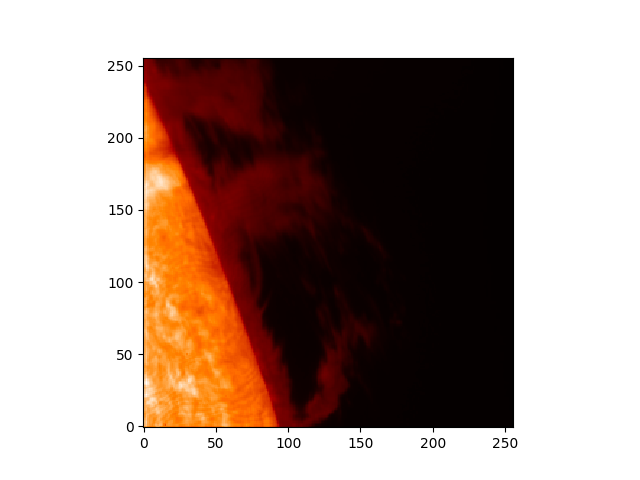

<IPython.core.display.Javascript object>


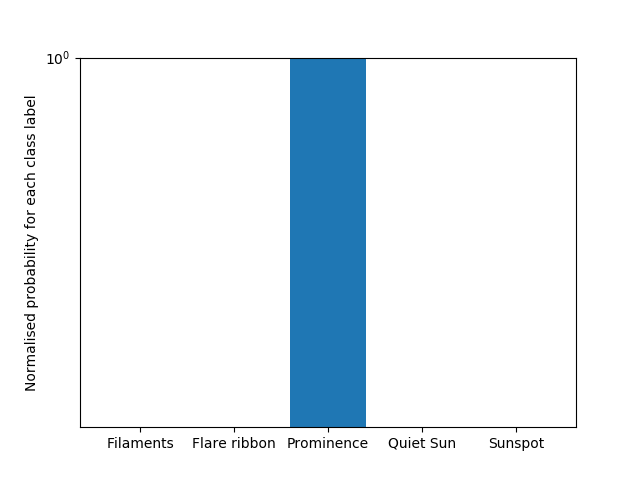

In [4]:
idx = next(iter(range(ans_dict["prominences"].shape[0])))
plot_dict = {
    "data" : new_im_arr,
    "feature_dict" : ans_dict,
    "feature" : "prominences",
    "idx" : idx,
    "cmap" : "hinodesotintensity"
}
plt.figure()
plot_image(**plot_dict)
plt.figure()
plot_hist(ans_hist_dict,"prominences",idx)